# Trends in Enhanced Vegetation Index in Bolivia

This notebook presents the analysis of crop productivity trends across Bolivia based on Enhanced Vegetation Index. By leveraging the satellite-derived vegetation indices, we aim to assess how crop yields have changed over time. EVI is specifically designed to optimize the sensitivity to high-biomass regions, reduce atmospheric and soil background noise, and provide a more accurate measure of vegetation health. Because EVI closely tracks photosynthetic activity and green biomass, it serves as a reliable proxy for crop yield.

## Data

This analysis utilizes two primary datasets:

* MODIS EVI Data: Sourced from NASA's Moderate Resolution Imaging Spectroradiometer (MODIS) on the Terra and Aqua satellites, this dataset provides EVI values at a 250-meter spatial resolution, with data collected every 16 days. The analysis focuses on yearly aggregated EVI values from 2014 to 2024.
* Global 30-meter Land Cover (GLC-FCS30D): This dataset offers detailed land cover classifications at a 30-meter resolution, spanning from 1985 to 2022. It is developed using continuous change detection methods and extensive Landsat imagery, providing annual updates and 35 land-cover subcategories.
* Administrative Boundaries: Geographic boundaries for Bolivia are sourced from the GeoBoundaries project. These boundaries are used to spatially aggregate EVI statistics and facilitate reporting at various administrative levels, thus enabling region-specific analysis of crop productivity trends.

## Methodology

The analysis follows these main steps:

#### Cropland Classification Selection

We focus exclusively on cropland areas, using the GLC-FCS30D land cover dataset. Specifically, we select all the following crop types:

* 10: Rainfed cropland
* 11: Herbaceous cover cropland
* 12: Tree or shrub cover cropland
* 20: Irrigated cropland

#### Masking EVI Data 

We created a binary mask for each cropland type and these cropland masks are applied to the EVI data, ensuring that only EVI values corresponding to cropland areas are included in the analysis. This step filters out non-cropland pixels and focuses the analysis on crop productivity.

#### Crop Seasonality

Using this time series dataset of EVI images, we apply several pre-processing steps to extract critical phenological parameters: start of season (SOS), middle of season (MOS), end of season (EOS), length of season (LOS), etc. This workflow is heavily inspired by the TIMESAT software, although in this implementation we use the `Phenolopy` open-source package. Below is the steps:

* Remove outliers from dataset on per-pixel basis using median method: outlier if median from a moving window < or > standard deviation of time-series times 2.
* Interpolate missing values linearly
* Smooth data on per-pixel basis (using Savitsky Golay filter, window length of 3, and polyorder of 1)

We then extract crop seasonality metrics using the seasonal amplitude method from the `phenolopy` package.

#### Time Series Construction and Zonal Statistics

For each region (as defined by administrative boundaries) and each cropland type, we constructed a time series of EVI values during the growing season. We aggregated the median values for each region and year, and summarizing the EVI trends over time for each cropland class.

#### Assumptions

In this analysis, we assume that no changes in cropland from 2022 onwards, as the GLC-FCS30D land cover data is only available up to 2022. For years after 2022, the cropland mask from 2022 is used.

## Import library and data

In [153]:
from pathlib import Path
import json
import logging

import ee
import geemap
from gee_zonal import ZonalStats
import geemap.colormaps as cm
import geopandas as gpd
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

logger = logging.getLogger(__name__)


PROJECT_ID = "ferrous-weaver-462011-d2"
ee.Initialize(project=PROJECT_ID)

PROJECT_ROOT = Path().cwd().parent
DATA_PATH = PROJECT_ROOT / "data"
BOUNDARIES_PATH = DATA_PATH / "boundaries"

ee.Initialize()

## Functions

In [154]:
def load_geojson_to_ee(
    geojson_path: str | Path,
) -> ee.FeatureCollection:
    """Load a GeoJSON file to Earth Engine.

    Args:
        geojson_path: The path to the GeoJSON file.

    Returns:
        An ee.FeatureCollection equivalent to the GeoJSON file.
    """
    if isinstance(geojson_path, str):
        geojson_path = Path(geojson_path)

    if not geojson_path.exists():
        raise FileNotFoundError(f"File not found: {geojson_path}")

    with open(geojson_path) as f:
        geojson = json.load(f)

    fc = ee.FeatureCollection(geojson)

    return fc


def fetch_boundaries(
    iso3_code: str,
    adm_level: int,
    release_type: str = "gbOpen",
    output_dir: str | Path = "../data/boundaries",
):
    """
    Fetch administrative boundaries from GeoBoundaries API.

    Args:
        iso3_code: ISO3 code of the country.
        adm_level: Administrative level (1, 2, etc.).
        release_type: Release type (e.g., "gbOpen", "gbCurrent").
        output_dir: Directory to save the downloaded GeoJSON file.

    Returns:
        An ee.FeatureCollection of the boundaries.
    """
    cache_dir = Path(output_dir)
    cache_dir.mkdir(parents=True, exist_ok=True)
    cache_file = cache_dir / f"{iso3_code}_ADM{adm_level}_{release_type}.geojson"

    if cache_file.exists():
        logger.info(f"Loading boundaries from cache: {cache_file}")
        return load_geojson_to_ee(cache_file)

    url = f"https://www.geoboundaries.org/api/current/{release_type}/{iso3_code}/ADM{adm_level}"
    logger.info(f"Fetching boundaries from API: {url}")
    response = requests.get(url)
    response.raise_for_status()
    download_url = response.json()["gjDownloadURL"]
    logger.info(f"Downloading GeoJSON from: {download_url}")
    gdf = gpd.read_file(download_url)
    gdf.to_file(cache_file, driver="GeoJSON")
    logger.info(f"Boundaries saved to cache: {cache_file}")
    return load_geojson_to_ee(cache_file)


def bitwiseExtract(value: ee.Image, fromBit: int, toBit: int | None = None) -> ee.Image:
    """Extract bits from a binary image."""
    toBit = fromBit if toBit is None else toBit
    maskSize = ee.Number(1).add(toBit).subtract(fromBit)
    mask = ee.Number(1).leftShift(maskSize).subtract(1)
    return value.rightShift(fromBit).bitwiseAnd(mask)


def apply_modisQA_mask(image: ee.Image):
    sqa = image.select("SummaryQA")
    dqa = image.select("DetailedQA")
    viQualityFlagsS = bitwiseExtract(sqa, 0, 1)
    viQualityFlagsD = bitwiseExtract(dqa, 0, 1)
    viSnowIceFlagsD = bitwiseExtract(dqa, 14)
    # Good data, use with confidence
    mask = (
        viQualityFlagsS.eq(0)
        .And(viQualityFlagsD.eq(0))
        .And(viQualityFlagsS.eq(1))
        .And(viQualityFlagsD.eq(1))
        .And(viSnowIceFlagsD)
        .eq(0)
    )
    return image.updateMask(mask)


def load_evi_data(
    start_date: str | ee.Date,
    end_date: str | ee.Date,
    apply_crop_mask: bool = True,
) -> ee.ImageCollection:
    """
    Load EVI data from MODIS.

    Args:
        start_date: Start date.
        end_date: End date.
        apply_crop_mask: Whether to apply crop mask.

    Returns:
        EVI image collection.
    """

    terra = (
        ee.ImageCollection("MODIS/061/MOD13Q1")
        .select(["EVI", "SummaryQA", "DetailedQA"])
        .filterDate(start_date, end_date)
    )

    aqua = (
        ee.ImageCollection("MODIS/061/MYD13Q1")
        .select(["EVI", "SummaryQA", "DetailedQA"])
        .filterDate(start_date, end_date)
    )

    mod13q1_QC = terra.map(apply_modisQA_mask)
    myd13q1_QC = aqua.map(apply_modisQA_mask)
    mxd13q1_cleaned = mod13q1_QC.select("EVI").merge(myd13q1_QC.select("EVI"))
    mxd13q1 = mxd13q1_cleaned.sort("system:time_start")
    return mxd13q1

In [155]:
bolivia_geom = fetch_boundaries("BOL", 0, "gbOpen")
evi_data = load_evi_data("2014-01-01", "2024-12-31", apply_crop_mask=False)
center = [-16.2902, -63.5887]

bolivia_bbox = bolivia_geom.geometry().bounds()
bolivia_bbox = ee.Geometry.BBox(-69.6450073, -22.8982742, -57.453, -9.6689438)

## load and preprocessing the GLC

In [156]:
annual = ee.ImageCollection("projects/sat-io/open-datasets/GLC-FCS30D/annual")

class_values = [
    10,
    11,
    12,
    20,
    51,
    52,
    61,
    62,
    71,
    72,
    81,
    82,
    91,
    92,
    120,
    121,
    122,
    130,
    140,
    150,
    152,
    153,
    181,
    182,
    183,
    184,
    185,
    186,
    187,
    190,
    200,
    201,
    202,
    210,
    220,
    0,
]
class_names = [
    "Rainfed_cropland",
    "Herbaceous_cover_cropland",
    "Tree_or_shrub_cover_cropland",
    "Irrigated_cropland",
    "Open_evergreen_broadleaved_forest",
    "Closed_evergreen_broadleaved_forest",
    "Open_deciduous_broadleaved_forest",
    "Closed_deciduous_broadleaved_forest",
    "Open_evergreen_needle_leaved_forest",
    "Closed_evergreen_needle_leaved_forest",
    "Open_deciduous_needle_leaved_forest",
    "Closed_deciduous_needle_leaved_forest",
    "Open_mixed_leaf_forest",
    "Closed_mixed_leaf_forest",
    "Shrubland",
    "Evergreen_shrubland",
    "Deciduous_shrubland",
    "Grassland",
    "Lichens_and_mosses",
    "Sparse_vegetation",
    "Sparse_shrubland",
    "Sparse_herbaceous",
    "Swamp",
    "Marsh",
    "Flooded_flat",
    "Saline",
    "Mangrove",
    "Salt_marsh",
    "Tidal_flat",
    "Impervious_surfaces",
    "Bare_areas",
    "Consolidated_bare_areas",
    "Unconsolidated_bare_areas",
    "Water_body",
    "Permanent_ice_and_snow",
    "Filled_value",
]
class_colors = [
    "#ffff64",
    "#ffff64",
    "#ffff00",
    "#aaf0f0",
    "#4c7300",
    "#006400",
    "#a8c800",
    "#00a000",
    "#005000",
    "#003c00",
    "#286400",
    "#285000",
    "#a0b432",
    "#788200",
    "#966400",
    "#964b00",
    "#966400",
    "#ffb432",
    "#ffdcd2",
    "#ffebaf",
    "#ffd278",
    "#ffebaf",
    "#00a884",
    "#73ffdf",
    "#9ebb3b",
    "#828282",
    "#f57ab6",
    "#66cdab",
    "#444f89",
    "#c31400",
    "#fff5d7",
    "#dcdcdc",
    "#fff5d7",
    "#0046c8",
    "#ffffff",
    "#ffffff",
]

# Mosaic the data into a single image
annual_mosaic = annual.mosaic()

years_list = [str(y) for y in range(2000, 2023)]
annual_mosaic_renamed = annual_mosaic.rename(years_list)

# Convert the multiband image to an ImageCollection
images = []
for year_str in years_list:
    year_int = int(year_str)
    date = ee.Date.fromYMD(year_int, 1, 1)
    image = annual_mosaic_renamed.select([year_str]).set(
        {"system:time_start": date.millis(), "system:index": year_str, "year": year_int}
    )
    images.append(image)

mosaics_col = ee.ImageCollection.fromImages(images)

recode = False
if recode:
    new_class_values = list(range(1, len(class_values) + 1))

    def remap_classes(image):
        return image.remap(class_values, new_class_values).rename("classification")

    mosaics_col = mosaics_col.map(remap_classes)

In [157]:
## Parameters

YEAR = 2014
CROPLAND_CLASS = 11

cropland_values = [10, 11, 12, 20]  # Values for cropland classes
crop_dict = {
    10: "Rainfed cropland",
    11: "Herbaceous cover cropland",
    12: "Tree or shrub cover cropland",
    20: "Irrigated cropland",
}

## Single cropland

In [54]:
image_sample = mosaics_col.filter(ee.Filter.eq("year", YEAR)).mosaic()
crop_sample = image_sample.updateMask(image_sample.eq(CROPLAND_CLASS))

m = geemap.Map(center=center, zoom=6, basemap="CartoDB.Positron")
m.addLayer(
    crop_sample,
    {},
    f"Land Cover {YEAR} - Cropland (Class {CROPLAND_CLASS})",
)
m

Map(center=[-16.2902, -63.5887], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

## Overall cropland

In [ ]:
image_sample = mosaics_col.filter(ee.Filter.eq("year", YEAR)).mosaic()

crop_mask = ee.Image(0)  # Start with an empty mask (all 0s)
for val in cropland_values:
    crop_mask = crop_mask.Or(image_sample.eq(val))

crop_sample = image_sample.updateMask(crop_mask)

m = geemap.Map(center=center, zoom=6, basemap="CartoDB.Positron")
m.addLayer(
    crop_sample,
    {},
    f"Land Cover {YEAR} - Cropland (Classes {', '.join(map(str, cropland_values))})",
    True,
)
m

## EVI based on single cropland

In [107]:
vis_params = {"min": -2000, "max": 10000, "palette": cm.get_palette("Greens", 20)}

image_subset = mosaics_col.filter(ee.Filter.eq("year", YEAR)).mosaic()
crop_mask = image_subset.eq(CROPLAND_CLASS)
evi_subset = evi_data.filterDate(
    ee.Date.fromYMD(YEAR, 1, 1), ee.Date.fromYMD(YEAR, 12, 31)
).mean()
evi_subset = evi_subset.updateMask(crop_mask)

m = geemap.Map(center=center, zoom=6, basemap="CartoDB.Positron")
m.addLayer(
    evi_subset,
    vis_params,
    f"Land Cover {YEAR}",
)
m

Map(center=[-16.2902, -63.5887], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

## EVI based on overall cropland

In [ ]:
vis_params = {"min": -2000, "max": 10000, "palette": cm.get_palette("Greens", 10)}

image_subset = mosaics_col.filter(ee.Filter.eq("year", YEAR)).mosaic()

crop_mask = ee.Image(0)
for val in cropland_values:
    crop_mask = crop_mask.Or(image_subset.eq(val))

evi_subset = evi_data.filterDate(
    ee.Date.fromYMD(YEAR, 1, 1), ee.Date.fromYMD(YEAR, 12, 31)
).mean()

evi_subset = evi_subset.updateMask(crop_mask).clip(bolivia_geom)

m = geemap.Map(center=center, zoom=6, basemap="CartoDB.Positron")
m.addLayer(
    evi_subset,
    vis_params,
    f"Land Cover {YEAR}",
)
m

Map(center=[-16.2902, -63.5887], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

In [42]:
def create_overall_evi(year: int = 2014):
    image_subset = mosaics_col.filter(ee.Filter.eq("year", year)).mosaic()

    crop_mask = ee.Image(0)
    for val in cropland_values:
        crop_mask = crop_mask.Or(image_subset.eq(val))

    evi_subset = evi_data.filterDate(
        ee.Date.fromYMD(year, 1, 1), ee.Date.fromYMD(year, 12, 31)
    ).mean()

    evi_subset = evi_subset.updateMask(crop_mask).clip(bolivia_geom)

    m = geemap.Map(center=center, zoom=6, basemap="CartoDB.Positron")
    m.addLayer(
        evi_subset,
        vis_params,
        f"Land Cover {year}",
    )
    return m

### 2014 EVI based on overall cropland

In [43]:
create_overall_evi(2014)

Map(center=[-16.2902, -63.5887], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=Search…

In [350]:
def create_evi_masked_by_year(year: int = 2014):
    crop_year = 2022 if year > 2022 else year
    image_subset = mosaics_col.filter(ee.Filter.eq("year", crop_year)).mosaic()

    crop_mask = ee.Image(0)
    for val in cropland_values:
        crop_mask = crop_mask.Or(image_subset.eq(val))

    evi_subset = evi_data.filterDate(
        ee.Date.fromYMD(year, 1, 1), ee.Date.fromYMD(year, 12, 31)
    )
    evi_subset = evi_subset.map(lambda img: img.updateMask(crop_mask))
    return evi_subset


def create_evi_image_collection(start_year: int = 2014, end_year: int = 2022):
    evi_collection = ee.ImageCollection([])
    for year in range(start_year, end_year + 1):
        evi_year = create_evi_masked_by_year(year)
        evi_collection = evi_collection.merge(evi_year)
    return evi_collection

In [351]:
run = False
if run:
    evi_recent = create_evi_image_collection(2019, 2024)
    bolivia_adm0 = fetch_boundaries("BOL", 0, "gbOpen")

    zs = ZonalStats(
        ee_dataset=evi_recent,
        target_features=bolivia_adm0,
        scale=250,
        statistic_type="median",
        output_dir="bolivia",
        output_name="bolivia_evi_stats",
    )

    zs.runZonalStats()

In [352]:
evi_df = pd.read_csv("../data/zonal_stats/bolivia_evi_stats.csv").rename(
    columns=lambda col: col[-14:] if col.endswith("_EVI") else col
)

phenology_df = (
    evi_df.copy()
    .rename(columns=lambda col: col[-14:] if col.endswith("_EVI") else col)
    .filter(regex="EVI|shape")
    .melt(
        id_vars=["shapeName", "shapeID", "shapeGroup", "shapeISO", "shapeType"],
        var_name="band_date",
        value_name="EVI",
    )
    .assign(
        date=lambda df: pd.to_datetime(
            df["band_date"].str.extract(r"(\d{4}_\d{2}_\d{2})")[0], format="%Y_%m_%d"
        ),
        EVI=lambda df: df["EVI"] / 10000,
    )
    .rename(columns={"shapeName": "region"})
    .pivot(index="date", columns="region", values="EVI")
)

phenology_df

region,Bolivia (Plurinational State *
date,
2019-01-01,0.483148
2019-01-09,0.502338
2019-01-17,0.495952
2019-01-25,0.502335
2019-02-02,0.515116
...,...
2024-11-24,0.380780
2024-12-02,0.470365
2024-12-10,0.483136


In [353]:
from scipy.signal import savgol_filter


def preprocess_series(series):
    """TIMESAT-style preprocessing."""
    series = series.interpolate(limit_direction="both")  # Step 2: Interpolate
    median = series.rolling(window=5, center=True).median()
    std_dev = series.std()
    series = series.mask(
        (series - median).abs() > 2 * std_dev
    )  # Step 1: Remove outliers
    series = series.interpolate(limit_direction="both")
    smoothed = savgol_filter(series, window_length=5, polyorder=2)  # Step 3: Smooth
    return smoothed


def extract_sos_mos_eos(smoothed, dates, threshold=0.2):
    max_val = smoothed.max()
    min_val = smoothed.min()
    amp = max_val - min_val
    sos = mos = eos = None
    for i in range(1, len(smoothed)):
        if sos is None and smoothed[i] > min_val + threshold * amp:
            sos = dates[i]
        if smoothed[i] == max_val:
            mos = dates[i]
        if sos is not None and smoothed[i] < min_val + threshold * amp:
            eos = dates[i]
            break
    return sos, mos, eos


monthly_df = phenology_df.copy()
monthly_df["month"] = monthly_df.index.month
monthly_df = monthly_df.groupby("month").mean()

season_dict = {}

for region in monthly_df.columns:
    series = monthly_df[region]
    smoothed = preprocess_series(series)
    sos, mos, eos = extract_sos_mos_eos(smoothed, monthly_df.index)
    season_dict[region] = {"SOS": sos, "MOS": mos, "EOS": eos}

## Insights

#### Growing season

The chart below shows the result of this process for a single crop pixel. The green dots represent the raw EVI values, the black line represents the processed EVI values, and the red dotted lines represent season parameters extracted for that pixel: start of season, peak of season, and end of season.

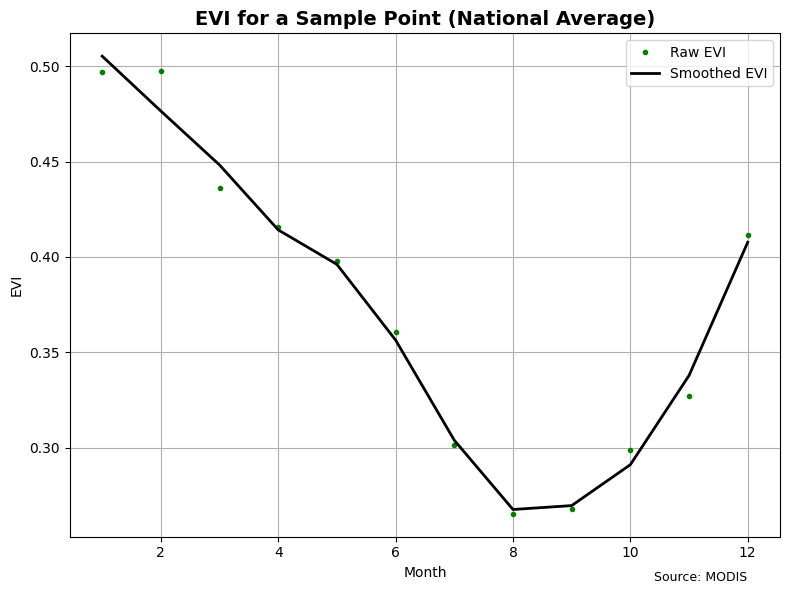

In [354]:
df = monthly_df.copy(deep=True)

plt.figure(figsize=(8, 6))
plt.plot(df.index, df, "o", color="green", markersize=3, label="Raw EVI")
plt.plot(df.index, smoothed, "k-", linewidth=2, label="Smoothed EVI")
plt.title("EVI for a Sample Point (National Average)", fontsize=14, weight="bold")
plt.ylabel("EVI")
plt.xlabel("Month")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.text(12, 0.23, "Source: MODIS", fontsize=9, ha="right")
plt.show()


Based on the phenology process, we identified the seasonality to start in October/November and end in March/April with the peak being in January. This can vary with geographic region and crop type as well, however, that has not been taken into consideration in this version.

## Zonal stats per crop value

In [355]:
run = False
if run:
    region_path = "../data/boundaries/BOL_ADM1_gbOpen.geojson"
    cropland_values = [10, 11, 12, 20]
    start_year = 2014
    end_year = 2024

    growing_season = ee.Filter.calendarRange(10, 3, "month")

    evi_collection = ee.ImageCollection([])
    crop_year = 2022 if end_year > 2022 else end_year
    for year in range(start_year, end_year + 1):
        for val in cropland_values:
            # Load crop mask for the specific year and value
            image_subset = mosaics_col.filter(ee.Filter.eq("year", crop_year)).mosaic()
            crop_mask = image_subset.eq(val)

            # Load EVI data for the specific year
            evi_subset = evi_data.filterDate(
                ee.Date.fromYMD(year, 1, 1), ee.Date.fromYMD(year, 12, 31)
            ).filter(growing_season)

            # Update the EVI image with the crop mask
            evi_subset = evi_subset.map(lambda img: img.updateMask(crop_mask))
            evi_subset = evi_subset.map(
                lambda img: img.set({"crop_value": val, "year": year})
            )
            evi_collection = evi_collection.merge(evi_subset)

    gdf = gpd.read_file(region_path)

    # Loop over each feature and each crop value, and run the zonal stats
    results = []
    for i in range(len(gdf)):
        feature = gdf.iloc[i : i + 1]
        print(
            f"Processing feature {i + 1}/{len(gdf)}: {feature['shapeName'].values[0]}"
        )
        for val in cropland_values:
            for year in range(start_year, end_year + 1):
                print(f"Processing year {year} for crop value {val}")
                evi_collection_filtered = evi_collection.filter(
                    ee.Filter.eq("crop_value", val)
                ).filter(ee.Filter.eq("year", year))
                zs = ZonalStats(
                    ee_dataset=evi_collection_filtered,
                    target_features=feature,
                    statistic_type="median",
                    scale=250,
                    output_dir="adm1 bolivia",
                    output_name=f"adm1_{feature['shapeName'].values[0]}_{year}_crop_{val}",
                )
                zs.runZonalStats()

In [159]:
zonal_stats_adm1_files = Path("../data/zonal_stats/adm1").glob("adm1_*.csv")
dfs = []
for file in zonal_stats_adm1_files:
    df = (
        (
            pd.read_csv(file)
            .rename(columns=lambda col: col[-14:] if col.endswith("_EVI") else col)
            .filter(regex="EVI|shape")
        )
        .assign(
            crop_value=file.stem.split("_")[-1],
            year=file.stem.split("_")[-3],
        )
        .drop(columns=["shapeGroup", "shapeISO"])
        .melt(
            id_vars=["shapeType", "shapeName", "shapeID", "crop_value", "year"],
            var_name="date",
            value_name="EVI",
        )
        .assign(
            date=lambda df: pd.to_datetime(
                df["date"].str.extract(r"(\d{4}_\d{2}_\d{2})")[0],
                format="%Y_%m_%d",
            )
        )
    )
    dfs.append(df)
zonal_stats_adm1_df = pd.concat(dfs, ignore_index=True)
# zonal_stats_adm1_df.to_csv("../data/zonal_stats/EVI trends ADM1.csv", index=False)

adm1_annual = (
    zonal_stats_adm1_df.sort_values("date")
    .rename(columns={"shapeName": "region"})
    .assign(
        year_month=lambda df: df["date"].dt.to_period("M").dt.to_timestamp(),
        year=lambda df: df["date"].dt.year,
        crop_type=lambda df: df["crop_value"]
        .astype(int)
        .map(crop_dict)
        .fillna("Other"),
    )
    .groupby(["region", "crop_type", "year"])["EVI"]
    .median()
    .reset_index()
)

#### EVI Trend over years across regions

The figure below displays Enhanced Vegetation Index (EVI) trends from 2014 to 2024 across Bolivia's nine administrative regions.

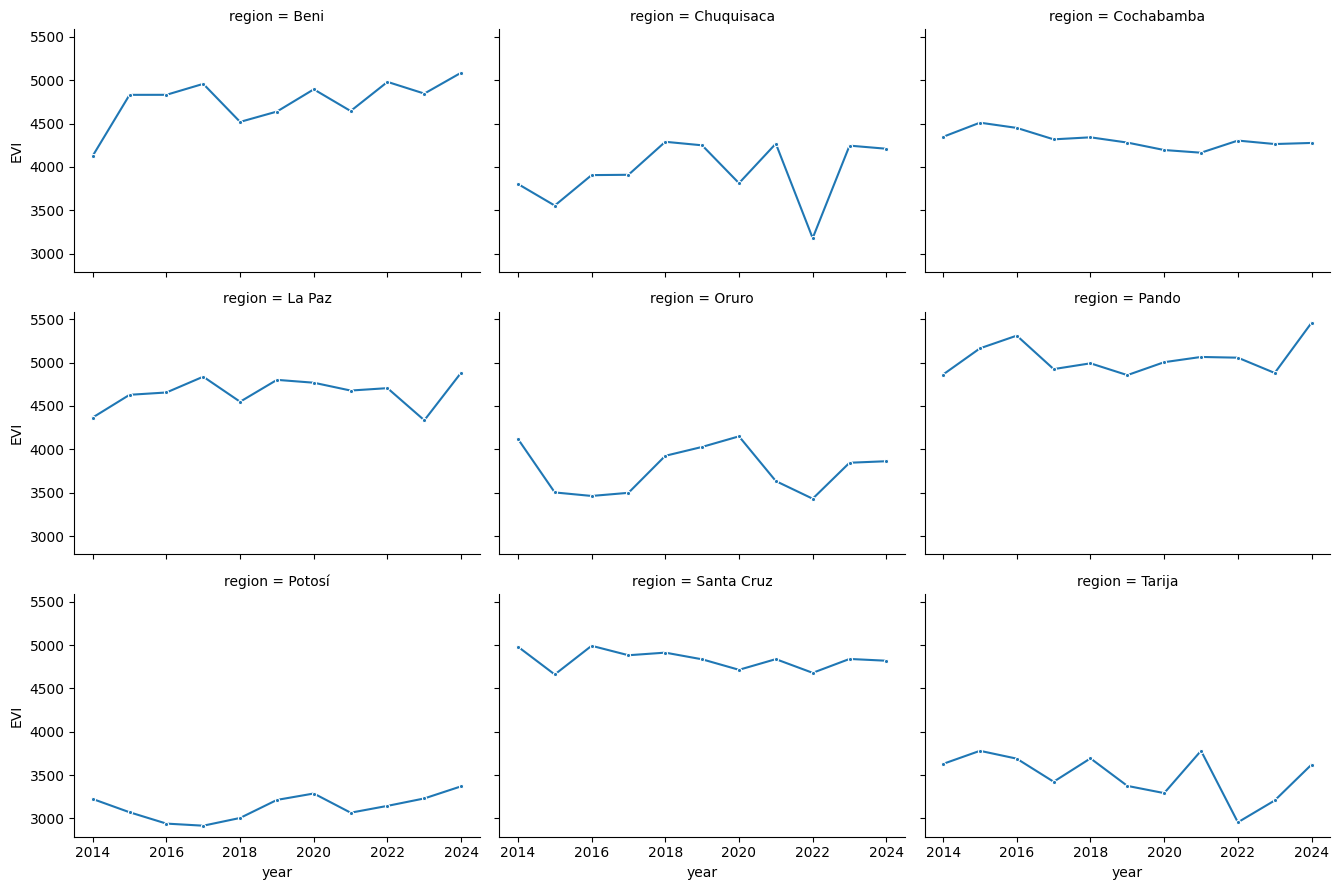

In [169]:
region_annual = adm1_annual.groupby(["region", "year"])["EVI"].median().reset_index()

g = sns.FacetGrid(
    region_annual,
    col="region",
    margin_titles=True,
    height=3,
    aspect=1.5,
    col_wrap=3,
)

g.map_dataframe(
    sns.lineplot,
    x="year",
    y="EVI",
    marker="o",
    markersize=3,
    linewidth=1.5,
);

#### EVI Trend over years across regions and crop types

The figure below displays Enhanced Vegetation Index (EVI) trends from 2014 to 2024 across Bolivia's nine administrative regions, segmented by four different cropland types.

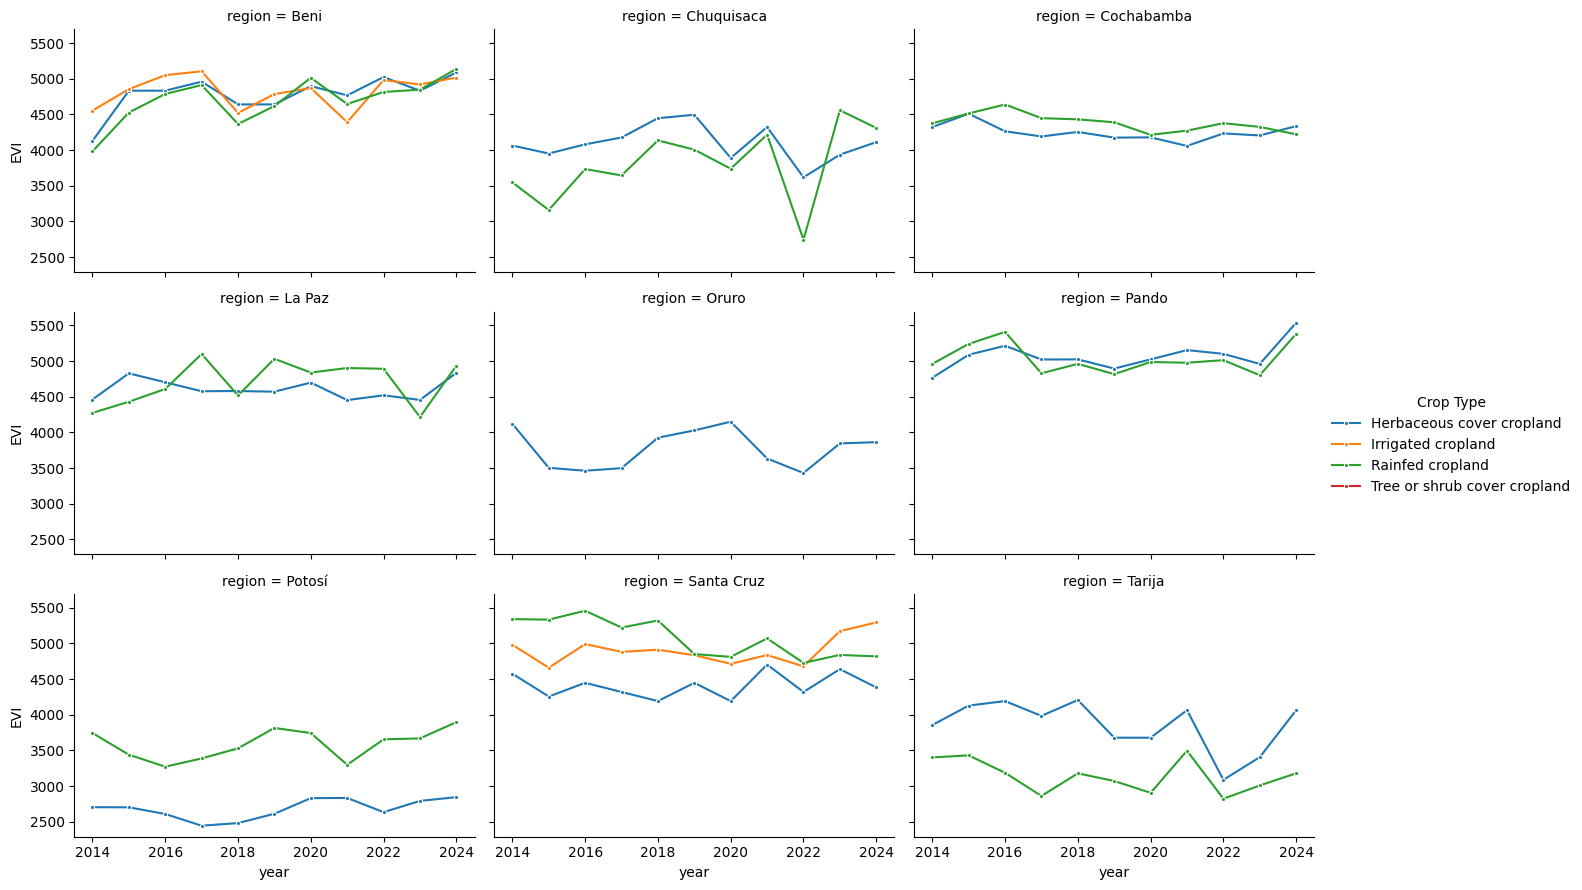

In [168]:
g = sns.FacetGrid(
    adm1_annual,
    col="region",
    margin_titles=True,
    height=3,
    aspect=1.5,
    col_wrap=3,
)

g.map_dataframe(
    sns.lineplot,
    x="year",
    y="EVI",
    hue="crop_type",
    marker="o",
    markersize=3,
    linewidth=1.5,
)

g.add_legend(title="Crop Type");

In [ ]:
run = False
if run:
    region_path = "../data/boundaries/BOL_ADM2_gbOpen.geojson"
    cropland_values = [10, 11, 12, 20]
    start_year = 2014
    end_year = 2024

    growing_season = ee.Filter.calendarRange(10, 3, "month")

    evi_collection = ee.ImageCollection([])
    crop_year = 2022 if end_year > 2022 else end_year
    for year in range(start_year, end_year + 1):
        for val in cropland_values:
            # Load crop mask for the specific year and value
            image_subset = mosaics_col.filter(ee.Filter.eq("year", crop_year)).mosaic()
            crop_mask = image_subset.eq(val)

            # Load EVI data for the specific year
            evi_subset = evi_data.filterDate(
                ee.Date.fromYMD(year, 1, 1), ee.Date.fromYMD(year, 12, 31)
            ).filter(growing_season)

            # Update the EVI image with the crop mask
            evi_subset = evi_subset.map(lambda img: img.updateMask(crop_mask))
            evi_subset = evi_subset.map(
                lambda img: img.set({"crop_value": val, "year": year})
            )
            evi_collection = evi_collection.merge(evi_subset)

    gdf = gpd.read_file(region_path)

    # Loop over each feature and each crop value, and run the zonal stats
    results = []
    nrows = len(gdf)
    # Loop through features in chunks to avoid memory issues
    chunk_size = 10  # Adjust based on your memory capacity
    for start in range(0, nrows, chunk_size):
        end = min(start + chunk_size, nrows)
        feature_chunk = gdf.iloc[start:end]
        print(f"Processing features {start + 1} to {end} of {nrows}")
        for val in cropland_values:
            for year in range(start_year, end_year + 1):
                print(f"Processing year {year} for crop value {val}")
                evi_collection_filtered = evi_collection.filter(
                    ee.Filter.eq("crop_value", val)
                ).filter(ee.Filter.eq("year", year))
                zs = ZonalStats(
                    ee_dataset=evi_collection_filtered,
                    target_features=feature_chunk,
                    statistic_type="median",
                    scale=250,
                    output_dir="adm2 bolivia",
                    output_name=f"adm2_batch_{start // chunk_size + 1}_crop_{val}_{year}",
                )
                print(f"adm2_batch_{start // chunk_size + 1}_crop_{val}_{year}")
                zs.runZonalStats()

In [175]:
zonal_stats_adm2_files = Path("../data/zonal_stats/adm2").glob("adm2_*.csv")
dfs = []
for file in zonal_stats_adm2_files:
    df = (
        (
            pd.read_csv(file)
            .rename(columns=lambda col: col[-14:] if col.endswith("_EVI") else col)
            .filter(regex="EVI|shape")
        )
        .assign(
            crop_value=file.stem.split("_")[-2],
            year=file.stem.split("_")[-1],
        )
        .drop(columns=["shapeGroup", "shapeISO"])
        .melt(
            id_vars=["shapeType", "shapeName", "shapeID", "crop_value", "year"],
            var_name="date",
            value_name="EVI",
        )
        .assign(
            date=lambda df: pd.to_datetime(
                df["date"].str.extract(r"(\d{4}_\d{2}_\d{2})")[0],
                format="%Y_%m_%d",
            )
        )
    )
    dfs.append(df)
zonal_stats_adm2_df = pd.concat(dfs, ignore_index=True).sort_values("date")
zonal_stats_adm2_df.to_csv("../data/zonal_stats/EVI trends ADM2.csv", index=False)

adm2_annual = (
    zonal_stats_adm2_df.sort_values("date")
    .rename(columns={"shapeName": "region"})
    .assign(
        year_month=lambda df: df["date"].dt.to_period("M").dt.to_timestamp(),
        year=lambda df: df["date"].dt.year,
        crop_type=lambda df: df["crop_value"]
        .astype(int)
        .map(crop_dict)
        .fillna("Other"),
    )
    .groupby(["region", "crop_type", "year"])["EVI"]
    .median()
    .reset_index()
)

The figure below displays Enhanced Vegetation Index (EVI) trends from 2014 to 2024 across top 10 level 2 administrative regions, segmented by four different cropland types.

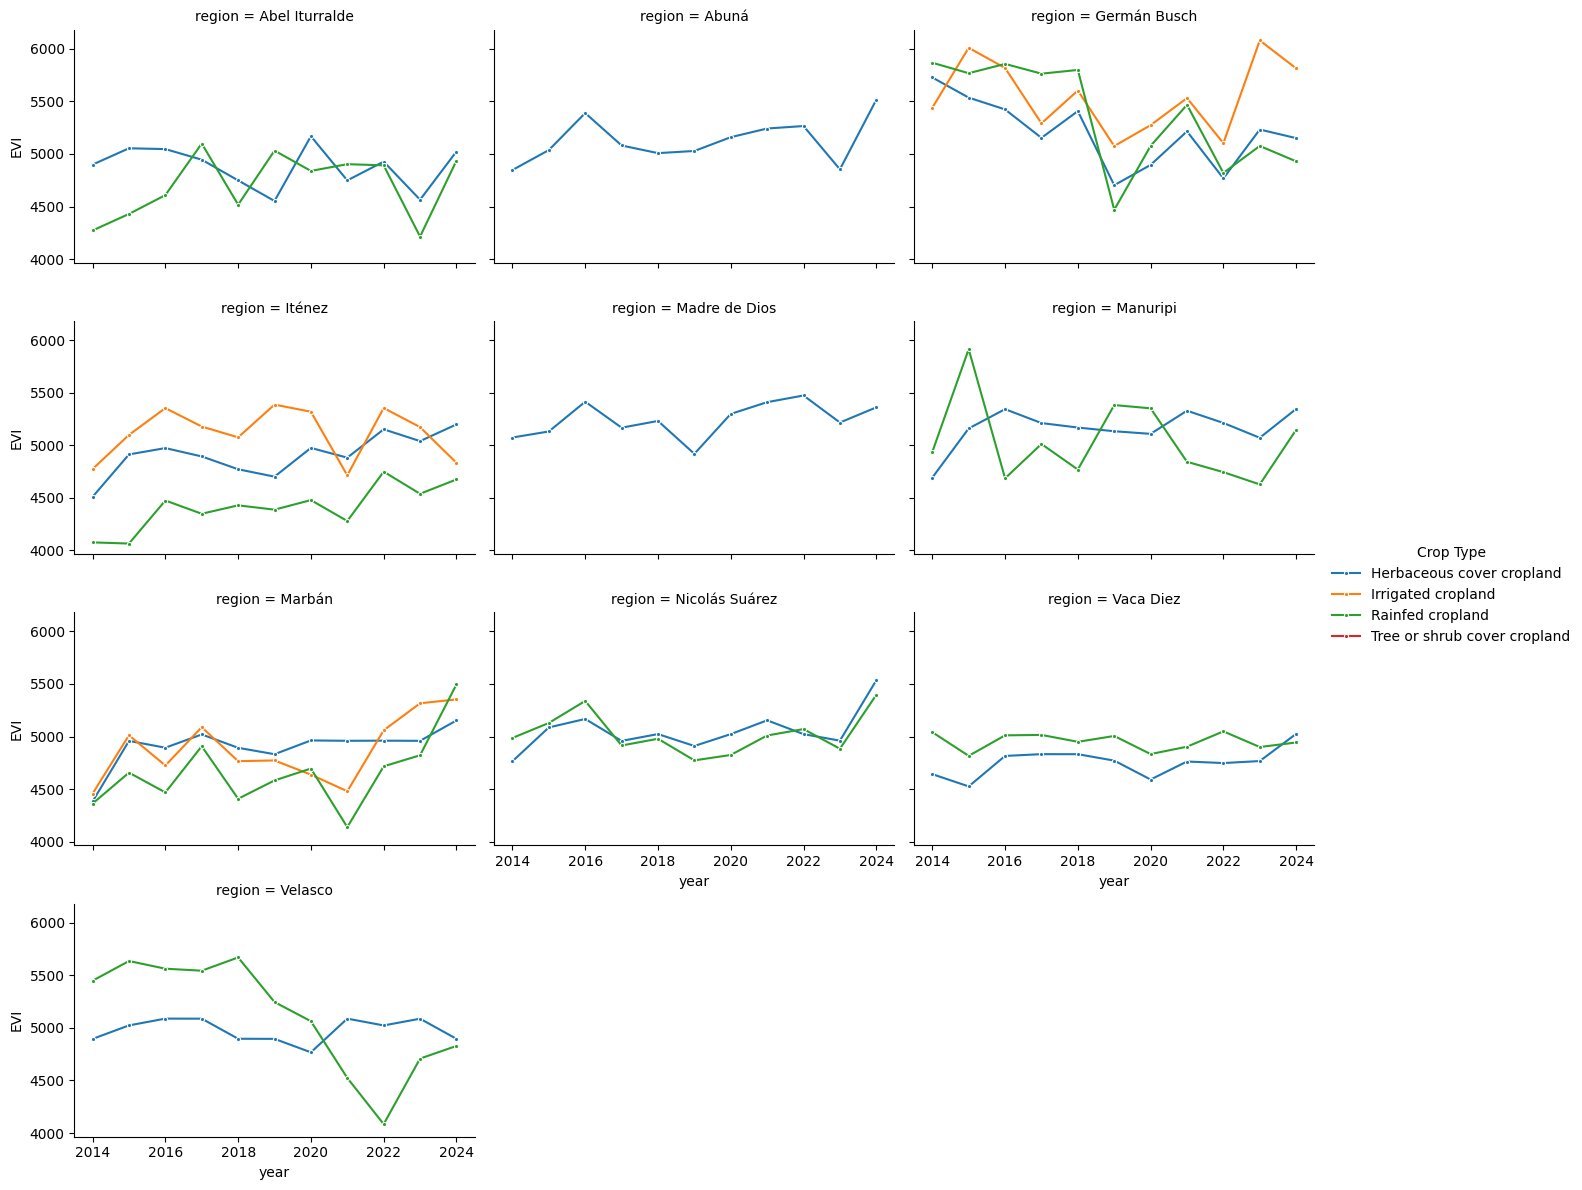

In [176]:
top_10_adm2 = adm2_annual.groupby("region")["EVI"].median().nlargest(10).index.tolist()
top_10_adm2_annual = adm2_annual[adm2_annual["region"].isin(top_10_adm2)]

g = sns.FacetGrid(
    top_10_adm2_annual,
    col="region",
    margin_titles=True,
    height=3,
    aspect=1.5,
    col_wrap=3,
)

g.map_dataframe(
    sns.lineplot,
    x="year",
    y="EVI",
    hue="crop_type",
    marker="o",
    markersize=3,
    linewidth=1.5,
)

g.add_legend(title="Crop Type");

This figure displays maps illustrating how EVI changed in each region annually.

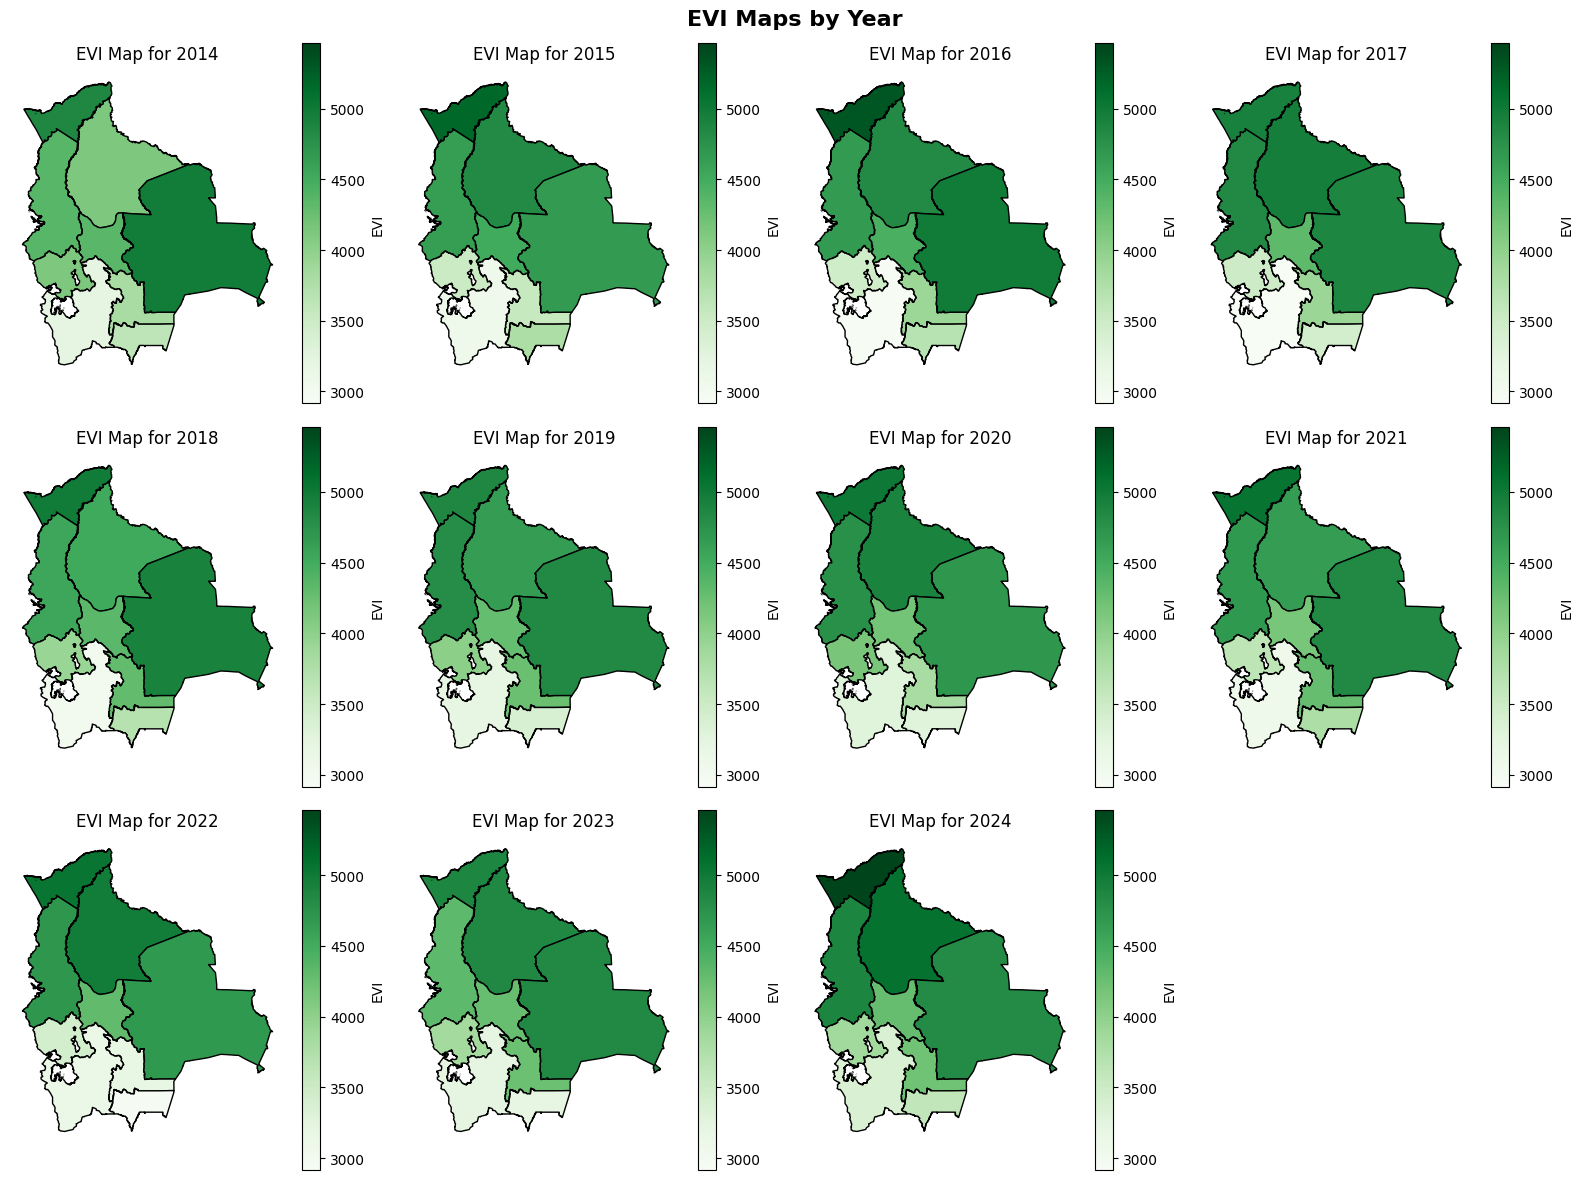

In [177]:
gdf = (
    gpd.read_file("../data/boundaries/BOL_ADM1_gbOpen.geojson")
    .rename(columns={"shapeName": "region"})
    .merge(adm1_annual, on="region", how="left")
    .groupby(["region", "year", "geometry"])["EVI"]
    .median()
    .reset_index()
    .pipe(lambda df: gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:4326"))
)


# Create maps facet plot per year
def plot_maps_per_year(gdf, start_year=2014, end_year=2024):
    years = range(start_year, end_year + 1)
    nrows = (len(years) + 2) // 4
    fig, axes = plt.subplots(nrows=nrows, ncols=4, figsize=(16, 4 * nrows))
    fig.suptitle("EVI Maps by Year", fontsize=16, weight="bold")
    axes = axes.flatten()

    # Calculate global min/max for consistent color scale
    vmin = gdf["EVI"].min()
    vmax = gdf["EVI"].max()

    for i, year in enumerate(years):
        ax = axes[i]
        gdf[gdf["year"] == year].plot(
            column="EVI",
            ax=ax,
            legend=True,
            cmap="Greens",
            edgecolor="black",
            vmin=vmin,
            vmax=vmax,
            legend_kwds={"label": "EVI"},
        )
        ax.set_title(f"EVI Map for {year}")
        ax.set_axis_off()

    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()


plot_maps_per_year(gdf, start_year=2014, end_year=2024)

### Crop land Area

Calculate the total cropland area for each region in 2015 and 2022

In [ ]:
region_path = "../data/boundaries/BOL_ADM2_gbOpen.geojson"
gdf = gpd.read_file(region_path)
cropland_values = [10, 11, 12, 20]

for year in [2015, 2022]:
    nrows = len(gdf)
    # Loop through features in chunks to avoid memory issues
    chunk_size = 10  # Adjust based on your memory capacity
    for start in range(0, nrows, chunk_size):
        end = min(start + chunk_size, nrows)
        feature_chunk = gdf.iloc[start:end]
        print(f"Processing features {start + 1} to {end} of {nrows}")
        crop_subset = mosaics_col.filter(ee.Filter.eq("year", year)).mosaic()
        crop_mask = ee.Image(0)
        for val in cropland_values:
            crop_mask = crop_mask.Or(crop_subset.eq(val))
        crop_subset = crop_subset.updateMask(crop_mask)
        zs = ZonalStats(
            target_features=feature_chunk,
            statistic_type="count",
            scale=30,
            ee_dataset=crop_subset,
            output_name=f"adm2_crop_count_{year}_batch_{start // chunk_size + 1}",
            output_dir="bolivia",
        )
        print(f"Running zonal stats for year {year}")
        zs.runZonalStats()


In [90]:
import ast


def load_dict(input_str):
    input_str = input_str.replace("null", "'null'")
    input_str = input_str.replace("=", ":")
    result_dict = ast.literal_eval(input_str)
    return result_dict


crop_count_files = list(Path("../data/zonal_stats/crop_count").glob("*.csv"))
dfs = []
for file in crop_count_files:
    df = pd.read_csv(file).assign(
        year=lambda df: file.stem.split("_")[-3],
        histogram=lambda df: df["histogram"].apply(load_dict),
    )
    dfs.append(df)

dfs = pd.concat(dfs, ignore_index=True)
dfs = (
    dfs.join(pd.json_normalize(dfs["histogram"]))
    .rename(
        # Null as other, and crop values as crop type names
        columns={
            "null": "Other",
            10: "Rainfed cropland",
            11: "Herbaceous cover cropland",
            12: "Tree or shrub cover cropland",
            20: "Irrigated cropland",
        }
        # Fill those crop types with 0 if NaN
    )
    .fillna(0)
    .drop(columns=["histogram"])
    .assign(**{"Tree or shrub cover cropland": 0})
    .assign(
        total_crop_area=lambda df: df["Herbaceous cover cropland"]
        + df["Rainfed cropland"]
        + df["Tree or shrub cover cropland"]
        + df["Irrigated cropland"]
    )
    .loc[
        :,
        [
            "year",
            "shapeName",
            "shapeID",
            "total_crop_area",
        ],
    ]
    .sort_values(["total_crop_area"], ascending=False)
)

dfs.to_csv("../data/zonal_stats/crop_count.csv", index=False)

Convert total crop area from square meters to hectare. Because each pixel is 900 square meters, so we multiply by 900 and divide by 10,000 to get the total crop area in hectares.

In [145]:
import numpy as np

df_area = (
    dfs.assign(
        year=lambda df: df["year"].astype(str),
        total_crop_area=lambda df: (df["total_crop_area"] * 900 / 10000),
    )
    .pivot(
        index=["shapeName", "shapeID"],
        columns="year",
        values="total_crop_area",
    )
    .reset_index()
    .rename(columns={"2015": "year 2015", "2022": "year 2022"})
    .assign(
        pct_change=lambda df: (df["year 2022"] - df["year 2015"])
        / df["year 2015"]
        * 100,
        abs_pct_change=lambda df: abs(df["pct_change"]),
    )
    .replace([float("inf"), np.nan], 0)
)


The table below shows top 10 region with the highest absolute percentage change compared between 2015 and 2022.

In [185]:
(
    df_area.loc[lambda df: df["year 2022"] > 500]
    .assign(
        pct_change=lambda df: df["pct_change"].round(2),
        abs_pct_change=lambda df: df["abs_pct_change"].round(2),
    )
    .sort_values("abs_pct_change", ascending=False)
    .drop(columns=["shapeID"])
    .rename(
        columns={
            "shapeName": "Region",
            "year 2015": "Crop Area 2015 (ha)",
            "year 2022": "Crop Area 2022 (ha)",
            "pct_change": "Percentage Change (%)",
            "abs_pct_change": "Absolute Percentage Change (%)",
        }
    )
    .head(10)
    .reset_index(drop=True)
    .rename_axis(None, axis=1)
)

,Region,Crop Area 2015 (ha),Crop Area 2022 (ha),Percentage Change (%),Absolute Percentage Change (%)
0,Ingavi,265.77,780.57,193.70,193.70
1,Los Andes,963.36,2114.01,119.44,119.44
2,Abel Iturralde,2320.56,4896.27,111.00,111.00
3,Velasco,192131.91,398822.40,107.58,107.58
4,Omasuyos,326.34,590.13,80.83,80.83
5,Moxos,8680.86,15600.87,79.72,79.72
6,Germán Busch,74953.35,132511.77,76.79,76.79
7,Marbán,42757.02,72476.19,69.51,69.51
8,Cercado,31963.77,54137.52,69.37,69.37
9,Iténez,10054.53,16584.30,64.94,64.94


The figure below shows the EVI trend from the top 10 regions with the highest absolute percentage change.

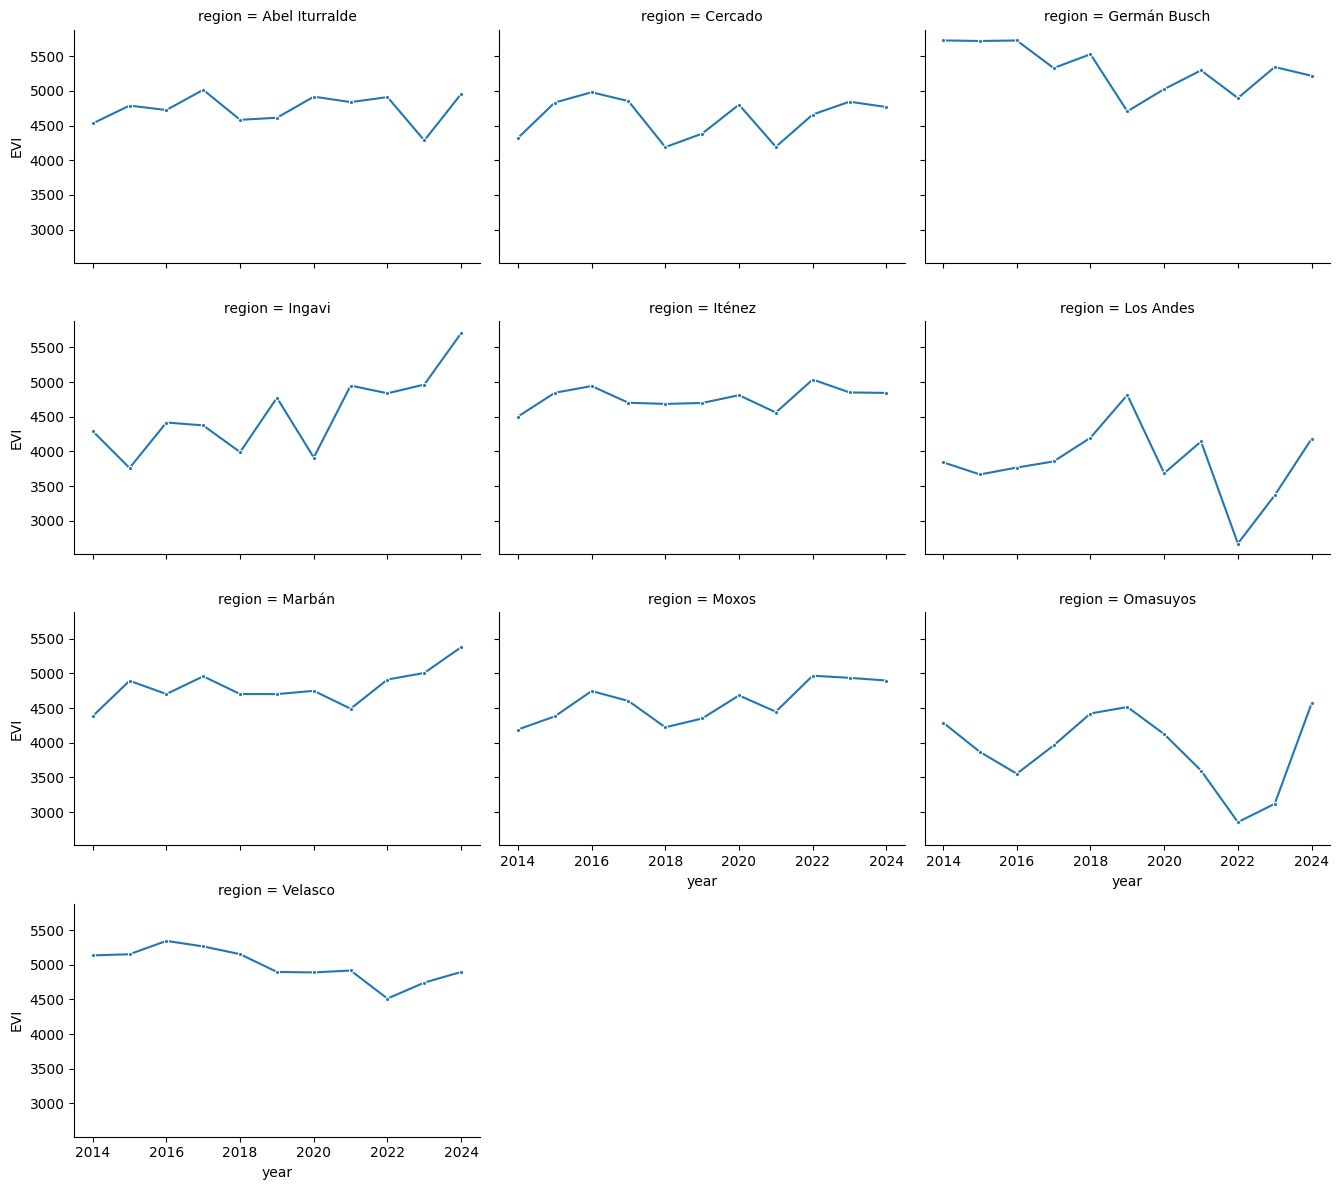

In [151]:
top10 = (
    df_area.loc[lambda df: df["year 2022"] > 500]
    .sort_values("abs_pct_change", ascending=False)
    .head(10)
    .loc[:, "shapeName"]
    .values
)

zonal_stats_adm2_df = pd.read_csv("../data/zonal_stats/EVI trends ADM2.csv")
top10_evi = (
    zonal_stats_adm2_df.loc[lambda df: df["shapeName"].isin(top10)]
    .groupby(["shapeName", "year"])["EVI"]
    .median()
    .reset_index()
    .rename(columns={"shapeName": "region"})
)

g = sns.FacetGrid(
    top10_evi,
    col="region",
    margin_titles=True,
    height=3,
    aspect=1.5,
    col_wrap=3,
)
g.map_dataframe(
    sns.lineplot,
    x="year",
    y="EVI",
    marker="o",
    markersize=3,
    linewidth=1.5,
);